# Studying similarities between cuisines 

The yummly dataset from <a href="https://www.kaggle.com/c/whats-cooking">kaggle</a> provides a unique way of studying the similarities between different types of cuisines. We often feel that certain types of cuisines are very similar. Local food traditions, and their similarities with other cuisines tell a lot about cultural and social mixing! This is my attempt at understanding this, and predicting cuisines from their ingredients.

In [92]:
from math import *
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import re
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

plt.rc('figure', figsize=(10, 6))
plt.style.use('ggplot')
%matplotlib inline

### I. Train dataset from yummly

We have a train dataset, that contains cuisine names and the corresponding ingredients. We read this into train_original, and sort the data by cuisine type.

In [2]:
train_original = pd.read_json("train.json")
train_original = train_original.sort_values('cuisine',kind='mergesort')

In [107]:
train_original.head(5)

,cuisine,id,ingredients
41,brazilian,31634,"[ice cubes, club soda, white rum, lime, turbin..."
380,brazilian,21052,"[eggs, hearts of palm, cilantro, coconut cream..."
423,brazilian,623,"[sweetened condensed milk, butter, cocoa powder]"
509,brazilian,26667,"[lime, crushed ice, simple syrup, cachaca]"
724,brazilian,15482,"[sugar, corn starch, egg whites, boiling water..."


### II. Cuisine names and count

We have a classification problem. So, the first step is realizing the number of cuisines or labels we have. We also need to know how biased, if at all, the given training set is.

In [3]:
def cuisines(df):
    """
    takes a dataframe as input and outputs
    a> a dictionary of all the cuisine names with frequency of occurance
    b> a numpy array labeling the cuisine names with integer values 0,1,2...
    """    
    # number of labels or number of different cuisine types
    cuisine_count = df['cuisine'].describe()[1]
    
    # labeling the differet cuisines as 0,1,2...
    # which will be necessary during the classification problem
    # cuisine_labels = np.arange(cuisine_count)
    
    # determining the name of the cuisine types in the train data set
    cuisine_names = []
    for row in df.itertuples():
        cuisine = row[1]
        if cuisine not in cuisine_names:
            cuisine_names.append(cuisine)
    
    # determining the number of occurence of each cuisine type 
    # in the train data set
    count = np.zeros(cuisine_count,float)
    # we create a dictionary of cuisine names and corresponding count
    cuisines = {}
    for row in df.itertuples():
        for i in xrange(cuisine_count):
            if row[1] == cuisine_names[i]:
                count[i] += 1.0
                cuisines[row[1]] = count[i] 
    
    return cuisines, cuisines.keys()

In [4]:
# getting the cuisine names and frequency for the train dataset

train_cuisines, train_cuisine_names = cuisines(train_original)

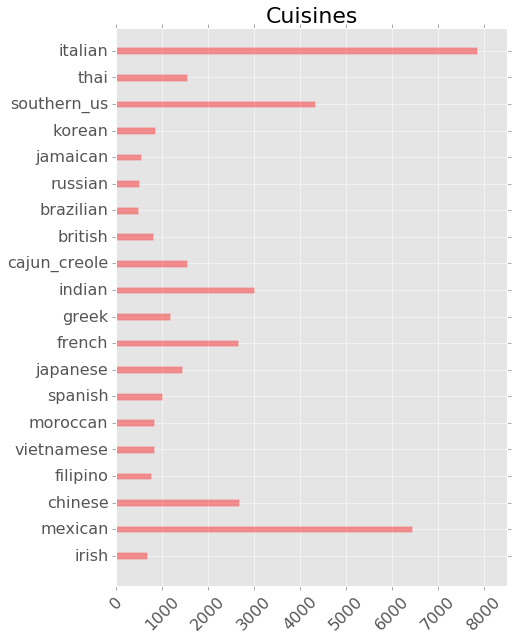

In [5]:
# plotting train_cuisines as a horizontal bar chart

plt.figure(figsize=(7, 10.0))
y_pos = np.arange(len(train_cuisines))
opacity=0.4
bar_width=0.25
plt.ylim(-1,len(train_cuisines))
plt.xlim(0,8500)
plt.barh(y_pos,train_cuisines.values(),bar_width,alpha=opacity,color='r')
plt.yticks(y_pos+bar_width/2.0, train_cuisines.keys(),fontsize=16)
plt.xticks(rotation=45,fontsize=16)
plt.grid(True)
plt.title('Cuisines',fontsize=22)
plt.show()

Thus, the given train dataset is higly skewed, with a majority of Italian, Mexican and Southern US recipes!

### III. Bag of ingredients

We create a *bag of ingredients*, similar to a *bag of words*, for each cuisine. We use word lemmatization, and then count vectorization, to create a list of *500* ingredients for each cuisine.

In [6]:
# for creating a bag of words, we write the ingredients list
# as a single string separated by space
train_original['ingredients_string'] = [" ".join(e) for e in train_original['ingredients']]

In [7]:
train_original.head(5)

,cuisine,id,ingredients,ingredients_string
41,brazilian,31634,"[ice cubes, club soda, white rum, lime, turbin...",ice cubes club soda white rum lime turbinado
380,brazilian,21052,"[eggs, hearts of palm, cilantro, coconut cream...",eggs hearts of palm cilantro coconut cream fla...
423,brazilian,623,"[sweetened condensed milk, butter, cocoa powder]",sweetened condensed milk butter cocoa powder
509,brazilian,26667,"[lime, crushed ice, simple syrup, cachaca]",lime crushed ice simple syrup cachaca
724,brazilian,15482,"[sugar, corn starch, egg whites, boiling water...",sugar corn starch egg whites boiling water col...


In [8]:
# we now use word lemmatization 
# and create a separate column of lemmatized ingredients
wnl = WordNetLemmatizer()
string_list = []
#train_original_check = train_original[0:5]
for row in train_original.itertuples(): 
    z = []
    for e in row[4].split():
        e = wnl.lemmatize(e)
        z.append(e)
    string_list.append(" ".join(z))
train_original.loc[:,('ingredients_lemmatize')] = string_list

In [9]:
train_original.head(5)

,cuisine,id,ingredients,ingredients_string,ingredients_lemmatize
41,brazilian,31634,"[ice cubes, club soda, white rum, lime, turbin...",ice cubes club soda white rum lime turbinado,ice cube club soda white rum lime turbinado
380,brazilian,21052,"[eggs, hearts of palm, cilantro, coconut cream...",eggs hearts of palm cilantro coconut cream fla...,egg heart of palm cilantro coconut cream flax ...
423,brazilian,623,"[sweetened condensed milk, butter, cocoa powder]",sweetened condensed milk butter cocoa powder,sweetened condensed milk butter cocoa powder
509,brazilian,26667,"[lime, crushed ice, simple syrup, cachaca]",lime crushed ice simple syrup cachaca,lime crushed ice simple syrup cachaca
724,brazilian,15482,"[sugar, corn starch, egg whites, boiling water...",sugar corn starch egg whites boiling water col...,sugar corn starch egg white boiling water cold...


We want to compare between different cuisines. The most direct and preliminary way of doing this is to compare the *bag of ingredients* between various cuisines. The cuisines with most number of common ingredients can be termed similar. We weight the importance of matching ingredients by the product of *normalized* term frequencies. The sum of such products can be used as a *similarity score*, and used to gauge the similarities between cuisines. We thus, to begin with, create a *bag of ingredients* for each cuisine for subsequent comparison.

In [10]:
def cuisine_ingredients(df,cuisine='indian'):
    """
    Takes as input
    a> a dataframe, maybe the train dataframe, with a column named 'ingredients_lemmatize'
    b> cuisine name, in the column named 'cuisine'
    returns a vocabulary of ingredients for that particular cuisine
    determined using CountVectorizer from scikit-learn.
    The vocbulary is a dictionary, with ingredient name and term frequency
    """
    # select the list of ingredients_strings from the dataframe
    # corresponding to that particular cuisine
    ingredients_strings = df.loc[df['cuisine']==cuisine]['ingredients_lemmatize']
    
    # initialize countvectorizer
    # we only keep the first 500 words
    # with max tf, to counter the fact
    # that the train set has unequal 
    # distribution of cuisines
    count_tf = CountVectorizer(analyzer = "word",
                               tokenizer = None,
                               preprocessor = None,
                               stop_words = 'english',
                               max_df = 0.25,
                               max_features = 500)
    # create the vocabulary or bag of ingredients
    # for the entered cuisine name
    count_tf.fit_transform( ingredients_strings )
    ingredients = count_tf.vocabulary_
    
    # each ingredient comes with a term frequency
    # we normalize this term frequency 
    # such that sum (tf^2) = 1
    # since, the similarity score between same cuisines has to be 1
    norm = 0.0
    for key in ingredients.keys():
        norm += np.power( ingredients[key],2 )
    
    for key in count_tf.vocabulary_.keys():
        ingredients[key] = ingredients[key]/float( np.power( (norm), 0.5) )
    
    # return the ingredients list for that cuisine
    # with normalized term frequency
    return ingredients

In [11]:
# create the ingredients list of each cuisine
# and store it as a dictionary with keys as cuisine names
# and ingredients as corresponding lists
ingredients_bag = {}
for cuisine in train_cuisine_names:
    ingredients_bag[cuisine] = cuisine_ingredients(train_original,cuisine=cuisine)

### III. Cuisine similarities

We determine the similarity between various cuisines depending on common ingredients and term frequency. This assigns a *normalized* similarity score. We rescale this score to a 1-5 scale.

In [85]:
def cuisine_similarity(cuisine_names):
    """
    Takes as input a list of cuisine names => train_cuisine_names
    and outputs a dictionary of dictionaries with
    keys: cuisine names
    values: dictionary => {cuisine_name1:similarity_score1,similarity_score_int1,
                           cuisine_name2:similarity_score2,similarity_score_int2,...}
    
    As a check, similarity score between same cuisines is 1 (this is the normalization used).
    """
    cuisine_similarity_score = {}
    
    def similarity_rescale(similarity_score):
        # we now rescale the similarity_score between 0.55-0.75 
        # rounded to a integer scale between 1-5
        # 1 => least similar, 5 => most similar
        # we choose a base of 0.55 since the minimum
        # similarity_score is roughly 0.55
        # so, any score <=0.55 we report as 1 in the
        # 1-5 integer scale
        # we choose a max of 0.75, since 
        # max scores is roughly around 0.75
        # so, scores >= 0.75, is 5 in the int scale
        score_int = round((similarity_score-0.55)*4/0.2+1)
        if score_int < 1.0:
            score_int = 1.0
        if score_int > 5.0:
            score_int = 5.0
        return score_int
    
    # calculate the original similarity scores between 0.0-1.0
    # and then rescale it according to the previous definition
    for e1 in cuisine_names:
        dict1 = ingredients_bag[e1]
        cases = {} 
        
        for e2 in cuisine_names:
            dict2 = ingredients_bag[e2]
            similarity = 0.0        
            
            for ing1 in dict1.keys():
                for ing2 in dict2.keys():
                    if ing1 == ing2:
                        similarity += dict1[ing1]*dict2[ing2]   
            
            # we only store scores for different cuisines
            # for same cuisines, similarity_score = 1
            if e2 != e1:
                similarity_score_int = similarity_rescale(similarity)
                cases[e2] = similarity_score_int
        cuisine_similarity_score[e1] = cases        
    
        
    return cuisine_similarity_score

In [86]:
cuisine_similarity_score = cuisine_similarity( train_cuisine_names )

In [87]:
def similarity_plot(cuisine_list):
    """Plots similarity scores as a bar chart for given list of cuisine names"""
    # figuring out the number of columns
    # and rows for the grid-plot
    # depends on len( cuisine_list )
    nplots = len( cuisine_list )
    if nplots%2==0:
        nrows = nplots/2
        ncols = 2
    elif nplots%2==1:
        if nplots/2==0:
            nrows = 1
            ncols = 1
        else:
            nrows = nplots/2+1
            ncols = 2
 
    figsize=[7.0*ncols,10*nrows]
    fig = plt.figure(figsize=figsize)
    opacity=0.4
    bar_width=0.25
    
    for i in xrange(nplots):
        # sub_plot index = j
        j = i+1
        cuisine_name = cuisine_list[i]
        count = len( cuisine_similarity_score[cuisine_name] )
        y_pos = np.arange( count )
        ax = fig.add_subplot(nrows,ncols,j)
        ax.set_ylim(-1,count )
        ax.set_xlim(0.0,5.0)
        ax.set_xticks([0.0,1.0,2.0,3.0,4.0,5.0])
        #ax.set_xlim(0.5,0.75)
        ax = plt.barh(y_pos,
                      cuisine_similarity_score[cuisine_name].values(),
                      bar_width,
                      alpha=opacity,
                      color='r')
        plt.yticks(y_pos+bar_width/2.0, cuisine_similarity_score[cuisine_name].keys(),fontsize=16)
        plt.xticks(rotation=45,fontsize=16)
        plt.grid(True)
        plt.title(cuisine_name,fontsize=22)
    
    # grid display spacing
    fig.tight_layout(w_pad=5.0, h_pad=2.0)
    plt.show()

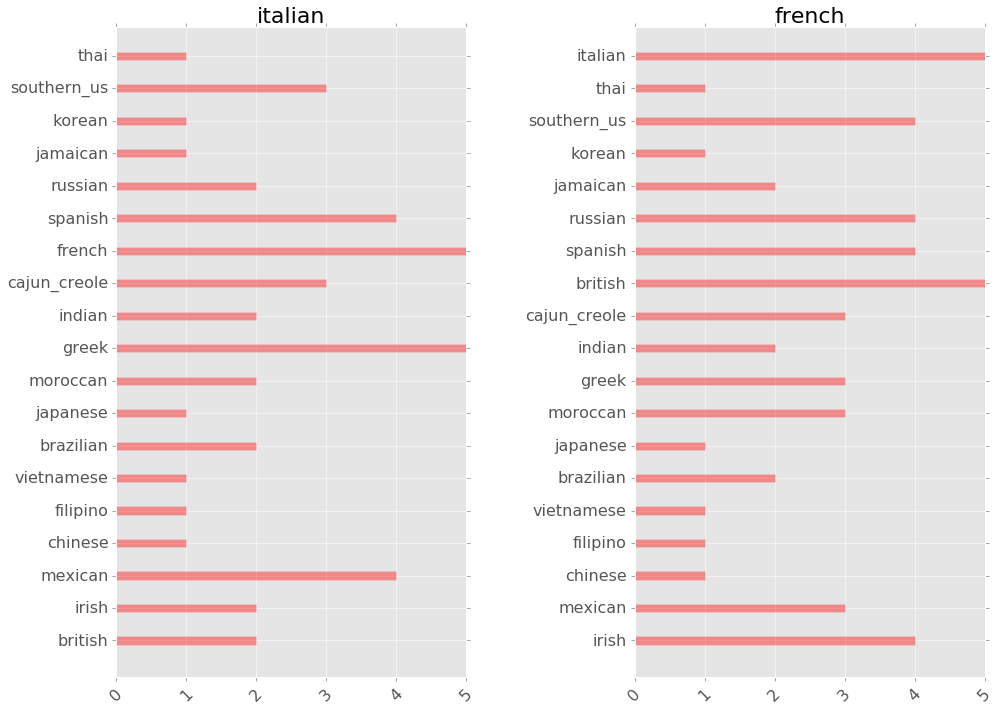

In [88]:
similarity_plot(['italian','french'])

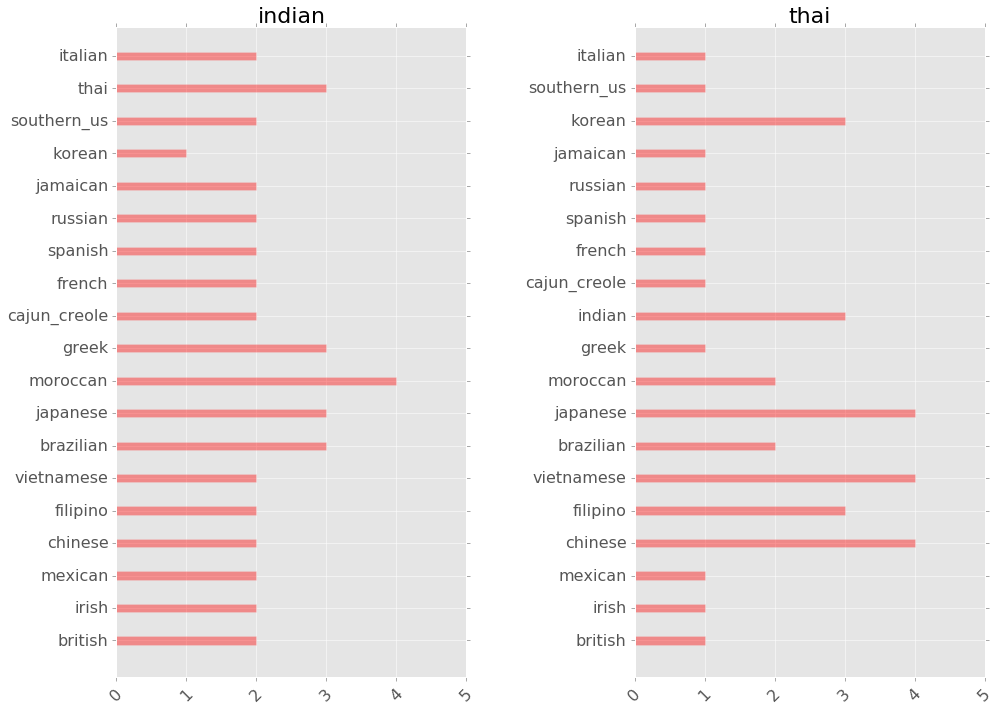

In [89]:
similarity_plot(['indian','thai'])

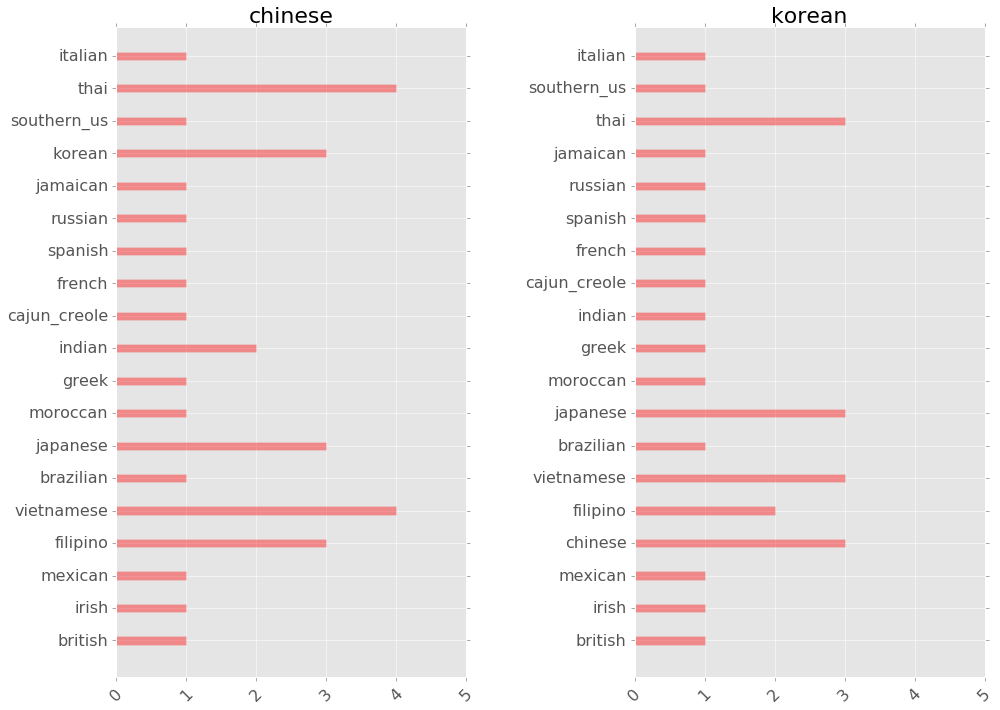

In [90]:
similarity_plot(['chinese','korean'])

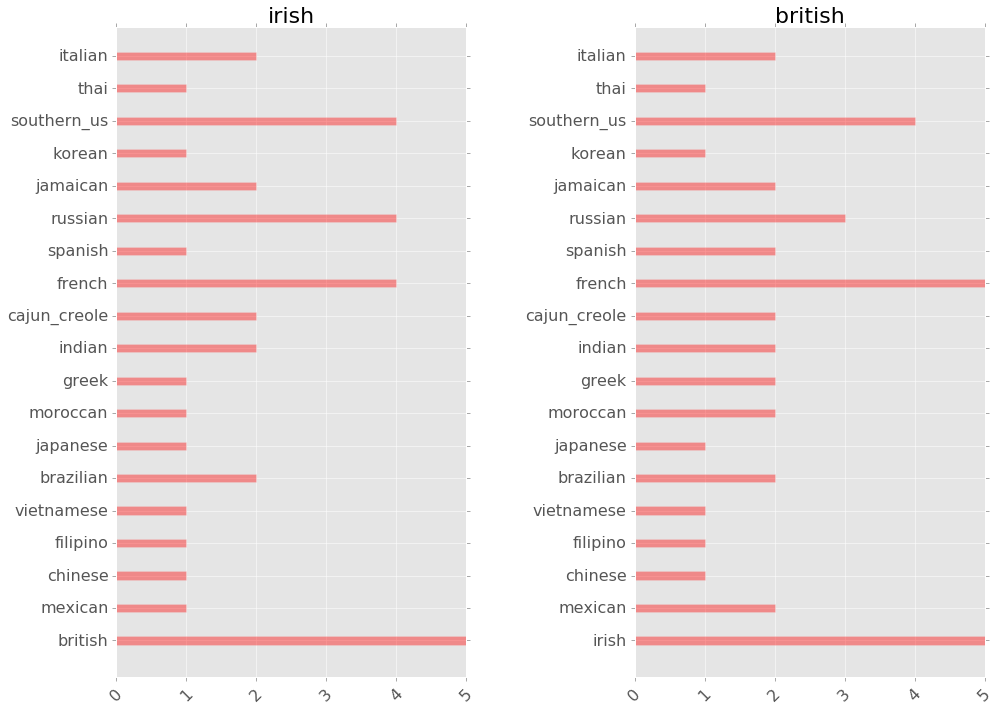

In [91]:
similarity_plot(['irish','british'])